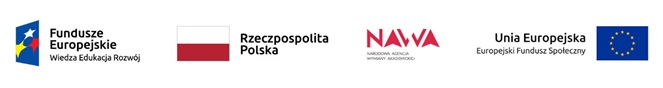

# Security of Big Data Analitics 

### Laboratory 07 "Evasion Attacks"

#### Please insert bellow your firstname, lastnema and ID number and run this cell 
##### (if cell is not active, clik twice on it)




The aim of the exercise is to illustrate the effect of evasion attacks. Adversarial example attack performed in the inference phase is the most studied security threat of AI system

During the exercise the secml library will be used. Link to the tutorial:https://github.com/pralab/secml/blob/master/tutorials/08-ImageNet.ipynb


 
### Evasion Attacks 

An evasion attack on the image classifier algorithm can be implemented as follows:

----------------------
#### 1.  Import needed libraries

In [ ]:
import secml
import torch

--------------------------
#### 2. Load the pretrained model

In this exercise,  a pretrained model from torchvision will be used (ResNet18 model). 

In [ ]:
from torchvision import models

# Download and cache pretrained model from PyTorch model zoo
model = models.resnet18(pretrained=True)


In [ ]:
import torch
from torch import nn

from secml.data import CDataset
from secml.ml.classifiers import CClassifierPyTorch
from secml.ml.features import CNormalizerMeanStd

# Random seed
torch.manual_seed(0)

criterion = nn.CrossEntropyLoss()
optimizer = None  # the network is pretrained

# imagenet normalization
normalizer = CNormalizerMeanStd(mean=(0.485, 0.456, 0.406),
                                std=(0.229, 0.224, 0.225))

# wrap the model, including the normalizer
clf = CClassifierPyTorch(model=model,
                         loss=criterion,
                         optimizer=optimizer,
                         epochs=10,
                         batch_size=1,
                         input_shape=(3, 224, 224),
                         softmax_outputs=False,
                         preprocess=normalizer,
                         random_state=0,
                         pretrained=True)

------------------------
#### 3. Doenload, load and classify an image

Now, a image downloaded from the web will be used to obtain the classification output. We use the PIL and io module for reading the image, requests for getting the image, and matplotlib for visualization.

Plese, download image African_Bush_Elephant.jpg from https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg and seve it in main directory of Jupiter Notebook

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

from PIL import Image
import requests
import io

# img_path = input("Insert image path:")
img_path = 'https://upload.wikimedia.org/wikipedia/commons/3/37/African_Bush_Elephant.jpg'
imga= 'African_Bush_Elephant.jpg'

#r = requests.get(img_path)
img = Image.open(imga)

# apply transform from torchvision
img_t = transform(img)

# convert to CArray
from secml.array import CArray
batch_t = torch.unsqueeze(img_t, 0).view(-1)
batch_c = CArray(batch_t.numpy())

# prediction for the given image
preds = clf.predict(batch_c)

---------------------
#### 4. Load a label

Now, the ImageNet human-readable labels, from a website, has to be load in order to get the string label with the class name. It is possible to display the image along with the predicted label.

In [ ]:
import json
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r.text))
label = preds.item()
predicted_label = labels[label]

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure()
fig.sp.imshow(img)
fig.sp.xticks([])
fig.sp.yticks([])
fig.sp.title(predicted_label)
fig.show()

-----------------------
#### 5. Run attack

We can create adversarial examples from this image. It is very sipmle, becaouse it will take no more than creating a CAttackEvasionPGDLS object. We should also apply the box constraint with the boundaries for the features lb and ub. Remember that this constraint will project the modified sample in the image space [0, 1], ensuring the adversarial example remains in the feasible space. The constraints are applied in the input space, before the image normalization.

In [ ]:
noise_type = 'l2'  # Type of perturbation 'l1' or 'l2'
dmax = 5  # Maximum perturbation
lb, ub = 0.0, 1.0 # Bounds of the attack space. Can be set to `None` for unbounded
y_target = 1  # None if `error-generic` or a class label for `error-specific`

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.01,
    'eta_min': 2.0,
    'max_iter': 100,
    'eps': 1e-3
}

from secml.adv.attacks import CAttackEvasionPGDLS
pgd_ls_attack = CAttackEvasionPGDLS(classifier=clf,
                                    double_init=False,
                                    distance=noise_type,
                                    dmax=dmax,
                                    solver_params=solver_params,
                                    y_target=y_target,
                                    lb=lb, ub=ub)

print("Attack started...")
eva_y_pred, _, eva_adv_ds, _ = pgd_ls_attack.run(batch_c, label)
print("Attack complete!")

adv_label = labels[clf.predict(eva_adv_ds.X).item()]

#### 6. Checking the effects of the attack carried out

In [ ]:
start_img = batch_c
eva_img = eva_adv_ds.X

# normalize perturbation for visualization
diff_img = start_img - eva_img
diff_img -= diff_img.min()
diff_img /= diff_img.max()

import numpy as np
start_img = np.transpose(start_img.tondarray().reshape((3, 224, 224)), (1, 2, 0))
diff_img = np.transpose(diff_img.tondarray().reshape((3, 224, 224)), (1, 2, 0))
eva_img = np.transpose(eva_img.tondarray().reshape((3, 224, 224)), (1, 2, 0))

fig = CFigure(width=15, height=5)
fig.subplot(1, 3, 1)
fig.sp.imshow(start_img)
fig.sp.title(predicted_label)
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 3, 2)
fig.sp.imshow(diff_img)
fig.sp.title("amplified perturbation")
fig.sp.xticks([])
fig.sp.yticks([])

fig.subplot(1, 3, 3)
fig.sp.imshow(eva_img)
fig.sp.title(adv_label)
fig.sp.xticks([])
fig.sp.yticks([])

fig.show()

-------------------------
# Exercise

1. Download new image, save it im main directory of studen user and run all cell code again;
Whether the attack was successful with the new image?

2. Downlowad seweral figures and compare results (sucess or not, can you see between origanal images and images after attac?)
    
3. Change the attack parameters (step 5) and check the effects of the attack (run all cell code again).

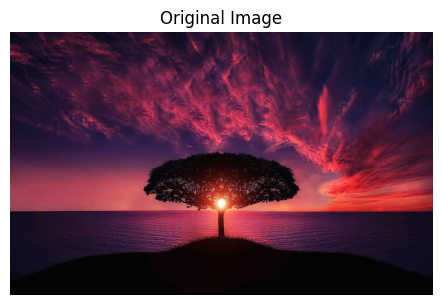

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the original and attacked images
original_image = Image.open('tree.jpg')
attacked_image = Image.open('attacked_image.jpg')

# Display the images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attacked_image)
plt.title('Attacked Image')
plt.axis('off')

plt.show()


your answers, conclusions (if not active click twice):


The project "Cyber Security for the European University EUNICE", implemented under the National Academic Exchange Agency's Strategic Partnerships Programme. Implemented in cooperation between the Poznan University of Technology and the University of Catania, University of Mons, and Brandenburg University of Technology.
 